<a href="https://colab.research.google.com/github/Sathyaseelan-Geo-Spatial-Lab/EMIT/blob/main/inference_on_raw_EMIT_nc_file_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run STARCOP models on full granules of EMIT data

>  V. Růžička, G. Mateo-Garcia, L. Gómez-Chova, A. Vaughan, L. Guanter, and A. Markham, [Semantic segmentation of methane plumes with hyperspectral machine learning models](https://www.nature.com/articles/s41598-023-44918-6). _Scientific Reports 13, 19999_ (2023). DOI: 10.1038/s41598-023-44918-6.

Demo with loading the AVIRIS trained models to show zero-shot generalisation on the data from EMIT.

*Update Jan 2025: the library versions were updated to work with the current Colab environment.*

In [2]:
# Try this first:
# !pip install git+https://github.com/spaceml-org/STARCOP.git

# But for Google Colab (as of January 2025) instead use:
!pip install git+https://github.com/spaceml-org/georeader.git
!pip install torch==2.0.0 torchvision==0.15.1 torchtext==0.15.1 pytorch-lightning==2.2
!pip install fsspec gcsfs omegaconf kornia==0.6.7  torchmetrics==0.10.0 wandb segmentation_models_pytorch hydra-core ipython rasterio  geopandas ipykernel matplotlib scikit-image scikit-learn wandb==0.13.3
!pip install netCDF4 spectral

!pip install huggingface_hub[cli,torch]
!pip install matplotlib-scalebar

  Cloning https://github.com/spaceml-org/georeader.git to /tmp/pip-req-build-3gif3wkm
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/georeader.git /tmp/pip-req-build-3gif3wkm
  Resolved https://github.com/spaceml-org/georeader.git to commit 164cb852924039bf925f2a9623898804996052df
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 62.4 MB/s eta 0:00:00
  Created wheel for georeader-spaceml: filename=georeader_spaceml-1.3.13-py3-none-any.whl size=165112 sha256=a7b35d44448d07c2e19d1b3e393c4182b9542a42b1ea403b211c7f6488a6ddad
  Stored in directory: /tmp/pip-ephem-wheel-cache-hyphgun1/wheels/cd/34/57/784cd337e7393b168823abf3147bf7921b7aca950b1bdb80da
Successfully built georeader-spaceml
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.7 MB/s eta 0:00:00


In [1]:
!git clone https://github.com/spaceml-org/STARCOP.git

fatal: destination path 'STARCOP' already exists and is not an empty directory.


In [2]:
%cd STARCOP

/content/STARCOP


## Step 1: download EMIT image

In order to download and process the EMIT image we will use the emit reader in the [georeader](https://github.com/spaceml-org/georeader/) package. See [this tutorial](https://github.com/spaceml-org/georeader/blob/main/notebooks/emit_explore.ipynb) for an example of how to load and plot the data.

In [3]:
from huggingface_hub import hf_hub_download
from georeader.readers import emit
from starcop.models import mag1c_emit
from georeader import plot
import starcop
from starcop.models.model_module import ModelModule
import os
import torch
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from starcop.models.utils import padding
import georeader

# link = emit.get_radiance_link("EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc")
# print("Download", link)

# # NASA's data archive requires creating an account for downloading EMIT files directly.
# # Add the user and password of the NASA Earthdata portal (https://search.earthdata.nasa.gov/search)
# product = emit.download_product(link,
#                                 auth=("user","password"))

# rst = emit.EMITImage(product)
# rst

/usr/local/lib/python3.11/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [4]:
!gdown 1cVRCSl8B5QMTQMoxdrMB7gkitbwMkyAf
!gdown 1BgP6accj0Scl6N7I1-gbkZ_wpkPg-sez
!ls

rst = emit.EMITImage("EMIT_L1B_RAD_001_20240724T081719_2420606_005.nc")
rst

Downloading...
From (original): https://drive.google.com/uc?id=1cVRCSl8B5QMTQMoxdrMB7gkitbwMkyAf
From (redirected): https://drive.google.com/uc?id=1cVRCSl8B5QMTQMoxdrMB7gkitbwMkyAf&confirm=t&uuid=7b762ed9-5177-471f-9b46-e74deaa1ea01
To: /content/STARCOP/EMIT_L1B_OBS_001_20240724T081719_2420606_005.nc
100% 109M/109M [00:01<00:00, 88.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1BgP6accj0Scl6N7I1-gbkZ_wpkPg-sez
From (redirected): https://drive.google.com/uc?id=1BgP6accj0Scl6N7I1-gbkZ_wpkPg-sez&confirm=t&uuid=9d665693-c21f-4da2-bb00-88cb1919aec5
To: /content/STARCOP/EMIT_L1B_RAD_001_20240724T081719_2420606_005.nc
100% 1.85G/1.85G [00:28<00:00, 64.3MB/s]
bash						 _illustrations  README.md		   scripts
EMIT_L1B_OBS_001_20240724T081719_2420606_005.nc  LICENSE	 requirements_package.txt  setup.py
EMIT_L1B_RAD_001_20240724T081719_2420606_005.nc  notebooks	 requirements.txt	   starcop


 
         File: EMIT_L1B_RAD_001_20240724T081719_2420606_005.nc
         Transform: | 0.00,-0.00, 77.87|
|-0.00,-0.00, 17.70|
| 0.00, 0.00, 1.00|
         Shape: (285, 1887, 1994)
         Resolution: (0.0005422325202601996, 0.0005422325202566469)
         Bounds: (77.8686515664556, 16.67929080148844, 78.94986321184679, 17.7024835672122)
         CRS: EPSG:4326
         units: uW/cm^2/SR/nm
        

In [ ]:
# alernatively for the sake of this demo, we also uploaded this scene on our gdrive (but if these two files are missing, please use the above download instead)
#!gdown 1jyFejO80Q82qUZ5tRPaDTqsBHefuXYa0
#!gdown 1a9k2YZDXfa4g95KlqCcKfkYcaA-QegYU
# !ls

# rst = emit.EMITImage("EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc")
# rst

bash						 _illustrations  README.md		   scripts
EMIT_L1B_OBS_001_20220827T060753_2223904_013.nc  LICENSE	 requirements_package.txt  setup.py
EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc  notebooks	 requirements.txt	   starcop


 
         File: EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc
         Transform: | 0.00,-0.00, 61.16|
|-0.00,-0.00, 36.83|
| 0.00, 0.00, 1.00|
         Shape: (285, 2007, 2239)
         Resolution: (0.0005422325202530942, 0.0005422325202530942)
         Bounds: (61.1592142222353, 35.74201728362127, 62.3732728350893, 36.8302779517758)
         CRS: EPSG:4326
         units: uW/cm^2/SR/nm
        

## Step 2: Load RGB

The RGB bands used to train the model correspond to the wavelengths 640nm, 550nm and 460nm respectively.

In [5]:
wavelengths_read = np.array([640, 550, 460])

bands_read = np.argmin(np.abs(wavelengths_read[:, np.newaxis] - rst.wavelengths), axis=1).tolist()
rst_rgb = rst.read_from_bands(bands_read)
rst_rgb

 
         File: EMIT_L1B_RAD_001_20240724T081719_2420606_005.nc
         Transform: | 0.00,-0.00, 77.87|
|-0.00,-0.00, 17.70|
| 0.00, 0.00, 1.00|
         Shape: (3, 1887, 1994)
         Resolution: (0.0005422325202601996, 0.0005422325202566469)
         Bounds: (77.8686515664556, 16.67929080148844, 78.94986321184679, 17.7024835672122)
         CRS: EPSG:4326
         units: uW/cm^2/SR/nm
        

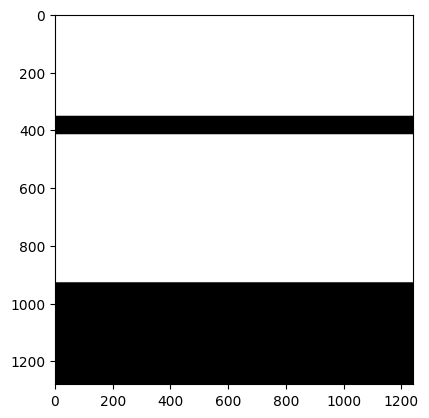

In [6]:
rgb_raw = rst_rgb.load_raw(transpose=True)
plt.imshow((rgb_raw/12).clip(0,1).transpose(1,2,0))

## Step 3: run mag1c on the EMIT product

Run mag1c filter retrieval based on the work of [Foote et al. 2020](https://ieeexplore.ieee.org/document/9034492).

In [7]:
mfoutput, albedo = mag1c_emit.mag1c_emit(rst, column_step=2, georreferenced=True)
mfoutput

	Running mag1c filter by columns: 100%|██████████| 621/621 [00:19<00:00, 31.81it/s]


 
         Transform: | 0.00,-0.00, 77.87|
|-0.00,-0.00, 17.70|
| 0.00, 0.00, 1.00|
         Shape: (1887, 1994)
         Resolution: (0.0005422325202601996, 0.0005422325202566469)
         Bounds: (77.8686515664556, 16.67929080148844, 78.94986321184679, 17.7024835672122)
         CRS: EPSG:4326
         fill_value_default: -9999.0
        

TypeError: Image data of dtype object cannot be converted to float

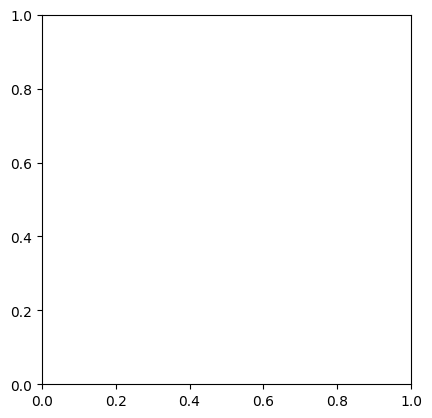

In [8]:
plt.imshow(mfoutput, vmin=0,vmax=1750)
plt.title("$\Delta$CH$_4$ [ppm x m]")
plt.colorbar()

## Step 4: Load STARCOP model

In [ ]:
from huggingface_hub import hf_hub_download
# experiment_name = "hyperstarcop_mag1c_only"
experiment_name = "hyperstarcop_mag1c_rgb"
subfolder_local = f"models/{experiment_name}"
config_file = hf_hub_download(repo_id="isp-uv-es/starcop",subfolder=subfolder_local, filename="config.yaml",
                              local_dir=".", local_dir_use_symlinks=False)
model_file = hf_hub_download(repo_id="isp-uv-es/starcop",subfolder=subfolder_local,
                             filename="final_checkpoint_model.ckpt",
                              local_dir=".", local_dir_use_symlinks=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:832: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


(…)odels/hyperstarcop_mag1c_rgb/config.yaml:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

final_checkpoint_model.ckpt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

In [ ]:
hsi_model_path = os.path.join(subfolder_local, "final_checkpoint_model.ckpt")
hsi_config_path =  os.path.join(subfolder_local, "config.yaml")

device = torch.device("cpu")
config_general = omegaconf.OmegaConf.load(os.path.join(os.path.dirname(os.path.abspath(starcop.__file__)), 'config.yaml'))

def load_model_with_emit(model_path, config_path):
    config_model = omegaconf.OmegaConf.load(config_path)
    config = omegaconf.OmegaConf.merge(config_general, config_model)

    model = ModelModule.load_from_checkpoint(model_path, settings=config)
    model.to(device)
    model.eval() # !

    print("Loaded model with",model.num_channels,"input channels")

    return model, config

hsi_model, hsi_config = load_model_with_emit(hsi_model_path, hsi_config_path)
print("successfully loaded HyperSTARCOP model!")

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.2.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint models/hyperstarcop_mag1c_rgb/final_checkpoint_model.ckpt`


Loaded model with 4 input channels
successfully loaded HyperSTARCOP model!


## Step 5: re-scale the input data

In [ ]:
# Data re-normalisation to fit the range of our models
# (these params were found from statistics of the training datasets and data ranges)

# DIV the EMIT data by
MAGIC_DIV_BY = 240.
RGB_DIV_BY = 20.
# clipping too large values
MAGIC_CLIP_TO = [0.,2.]
RGB_CLIP_TO =   [0.,2.]
# MULT_BY to get it back to the range we saw in the AVIRIS data ...
MAGIC_MULT_BY = 1750.
RGB_MULT_BY =   60.


# NORMALISE
# emit rgb has max ~22
e_mag1c = np.clip(mfoutput / MAGIC_DIV_BY, MAGIC_CLIP_TO[0], MAGIC_CLIP_TO[1]) * MAGIC_MULT_BY
e_rgb = np.clip(rgb_raw / RGB_DIV_BY, RGB_CLIP_TO[0], RGB_CLIP_TO[1]) * RGB_MULT_BY
input_data = np.concatenate([e_mag1c[None], e_rgb], axis=0)
input_data.shape

(4, 1280, 1242)

## Step 6: run inference

In [ ]:
pred = padding.padded_predict(input_data, model=lambda x: torch.sigmoid(hsi_model(x)))
pred.shape

(1, 1280, 1242)

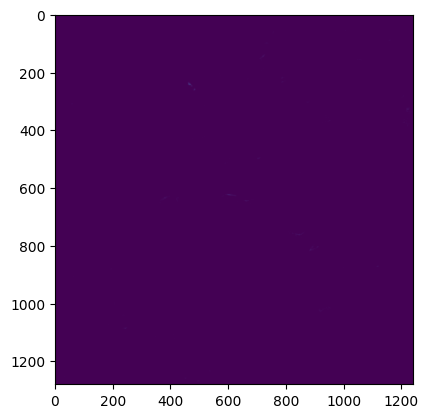

In [ ]:
plt.imshow(pred[0],vmin=0,vmax=1)

## Step 7: georreference and plot results

In [ ]:
crs_utm = georeader.get_utm_epsg(rst.footprint("EPSG:4326"))
emit_image_utm = rst.to_crs(crs_utm)

In [ ]:
mfgeo = emit_image_utm.georreference(mfoutput, fill_value_default=-1)
predgeo = emit_image_utm.georreference(pred[0], fill_value_default=0)
rgbgeo = emit_image_utm.georreference(rgb_raw, fill_value_default=-1)

<Axes: title={'center': 'pred'}>

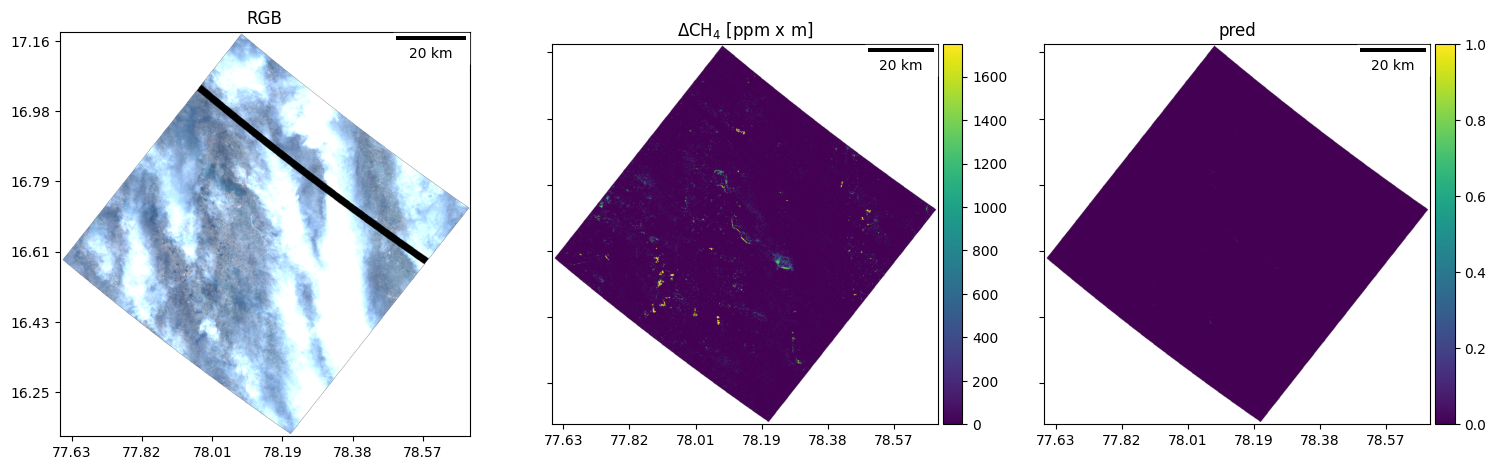

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,6),sharey=True)

rgbgeomask = np.any(rgbgeo.values == -1, axis=0,keepdims=False)
rgbplot = (rgbgeo/12).clip(0,1)
rgbplot.values[:, rgbgeomask] = -1
plot.show(rgbplot, ax=ax[0], title= "RGB",mask=True, add_scalebar=True)
plot.show(mfgeo, ax=ax[1], title= "$\Delta$CH$_4$ [ppm x m]",mask=True,vmin=0, vmax=1750,
         add_colorbar_next_to=True, add_scalebar=True)
plot.show(predgeo, ax=ax[2], title= "pred", mask=True, vmin=0, vmax=1, add_scalebar=True,
          add_colorbar_next_to=True)

## Licence

The *STARCOP* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

 If you find this work useful please cite:
```
@article{ruzicka_starcop_2023,
	title = {Semantic segmentation of methane plumes with hyperspectral machine learning models},
	volume = {13},
	issn = {2045-2322},
	url = {https://www.nature.com/articles/s41598-023-44918-6},
	doi = {10.1038/s41598-023-44918-6},
	number = {1},
	journal = {Scientific Reports},
	author = {Růžička, Vít and Mateo-Garcia, Gonzalo and Gómez-Chova, Luis and Vaughan, Anna, and Guanter, Luis and Markham, Andrew},
	month = nov,
	year = {2023},
	pages = {19999}
}
```